In [1]:
from prody import *
import numpy as np
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearnex import patch_sklearn
from scipy.sparse.linalg import eigsh
import scipy
import os
import wget
import shutil
import gzip
import numba as nb

C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\numba_dppy\config.py:55: UserWarning: Please install dpctl 0.8.* or higher.
  warnings.warn(msg, UserWarning)


In [2]:
pdb = '1a34'
n_modes = 60
filename = pdb + '.pdb'

if not os.path.exists(filename):
    vdb_url = 'https://files.rcsb.org/download/' + pdb + '.pdb.gz'
    print(vdb_url)
    vdb_filename = wget.download(vdb_url)
    with gzip.open(vdb_filename, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
           shutil.copyfileobj(f_in, f_out)

In [3]:
capsid = parsePDB(filename, biomol=True)

calphas = capsid.select('ca').copy()
n = calphas.getCoords().shape[0]
print(n)
cutoff = 10.0

@> 22070 atoms and 1 coordinate set(s) were parsed in 0.14s.
@> Biomolecular transformations were applied to the coordinate data.


16320


In C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\colin\Miniconda3\envs\idp\lib\site-packa

<Axes3D:xlabel='x', ylabel='y'>

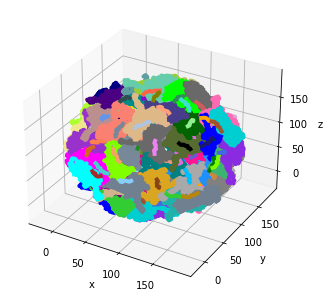

In [4]:
showProtein(calphas)

In [5]:
type = 'anm'
if type == 'anm':
    anm = ANM(pdb + '_full')
    anm.buildHessian(calphas, cutoff=cutoff, kdtree=True, sparse=True)
    print(calphas.getCoords().shape[0])
    evals, evecs = eigsh(anm.getHessian(), k=n_modes, sigma=1E-5, which='LA')
    anm._eigvals = evals
    anm._n_modes = len(evals)
    anm._eigvecs = evecs
    anm._vars = 1/evals
    anm._array = evecs
    model = anm
elif type == 'gnm':
    gnm = GNM(pdb + '_full')
    gnm.buildKirchhoff(calphas, cutoff=cutoff, kdtree=True, sparse=True)
    print(calphas.getCoords().shape[0])
    evals, evecs = eigsh(gnm.getKirchhoff(), k=n_modes, sigma=1E-8, which='LA')
    gnm._eigvals = evals
    gnm._n_modes = len(evals)
    gnm._eigvecs = evecs
    gnm._vars = 1/evals
    gnm._array = evecs
    model = gnm

@> Using KDTree for building the Hessian.
@> Hessian was built in 44.71s.


16320


C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [6]:
distFlucts = calcDistFlucts(model, norm=False)
n = distFlucts.shape[0]
print(n)
nearestNeighs = np.full((n, n), True, dtype=bool)
np.fill_diagonal(nearestNeighs, False)
dist = buildDistMatrix(calphas.getCoords())
nearestNeighs &= (dist <= cutoff)
nnDistFlucts = distFlucts[nearestNeighs]
sigma = 1/(2*np.mean(nnDistFlucts)**2)
sims = np.exp(-sigma*distFlucts*distFlucts)*nearestNeighs
from scipy import sparse
sims = sparse.csr_matrix(sims)

16320


In [7]:
from sklearnex import patch_sklearn
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
patch_sklearn()

def spectral_raw(sims, calphas, n_range):
    quality = []
    labels = []
    cluster_types = []
    n_c = calphas.getCoords().shape[0]
    for n_clusters in n_range:
        print(n_clusters)
        clust = SpectralClustering(n_clusters = n_clusters, n_init=500, affinity='precomputed').fit(sims)
        label = clust.labels_
        labels.append(label)
        __, counts = np.unique(label, return_counts=True)
        cluster_types.append(counts)
    return quality, labels, cluster_types




Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
n_range = [12, 20, 30, 32, 60] 
quality, labels, cluster_types = spectral_raw(sims, calphas, n_range)

12
20
30
32
60


In [19]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores = []
devs = []
for n in range(len(n_range)):
    domains = labels[n]
    __, counts = np.unique(domains, return_counts = True)
    devs.append(np.std(counts))
    testScore = silhouette_score(distFlucts, domains, metric='precomputed')
    scores.append(testScore)
    print(len(np.unique(domains)))
    calphas.setData('b',domains)
    nc = str(n_range[n])
    writePDB(pdb + '_' + nc + '_domains.pdb',calphas,beta=domains)



12
20
30
32
60


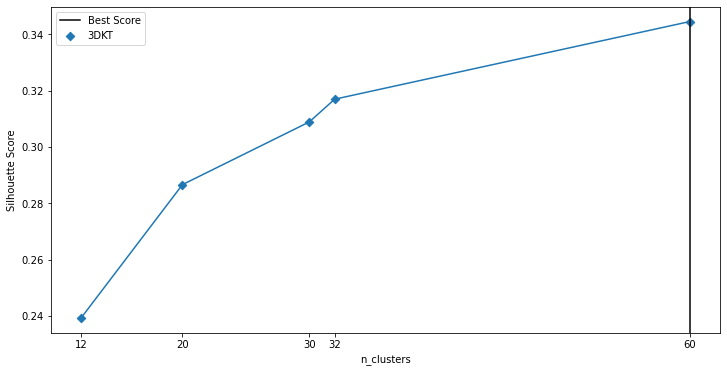

In [20]:
# cluster_similarity = [np.var(t)/(np.mean(t)) for t in cluster_types]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(n_range, scores, marker = 'D', label=pdb)
ax.plot(n_range, scores)
ax.axvline(x = n_range[np.argmax(scores)], label = 'Best Score', color = 'black')
ax.set_xticks(n_range)
ax.set_xlabel('n_clusters')
ax.set_ylabel('Silhouette Score')
ax.legend()
# ax[1].plot([32,60,90], cluster_types)
# ax[1].set_ylabel('Unique Clusters')
# fig.tight_layout()
plt.show()

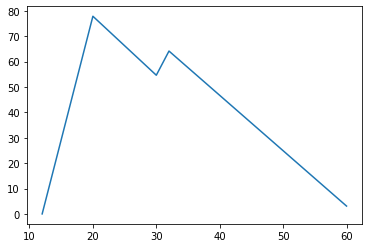

In [21]:
plt.plot(n_range, devs)

In [12]:
import nglview
file = '3dkt_12_domains.pdb'

view = nglview.show_file(file)  # load "3pqr" from RCSB PDB and display viewer widget
view.update_representation(color_scheme='bfactor')
view.background = 'black'
view

NGLWidget(background='black')